<a href="https://colab.research.google.com/github/danielabebe1/CapstoneProject1/blob/master/Capstone1_Milestone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project I

## Predicting Pain Relievers 

Both prescribed and non-prescribed use of pain relievers, as well as rates of opioid-related mortality and admissions to emergency departments, have increased in the last few years. There is no exact figure on how many people are affected by this problem but the number has increased according to ‘National Center for Biotechnology Information’. There are many different pain relievers, and each one has advantages and risks. Some types of pain respond better to certain medicines than others. Each person has a different response to a pain reliever for the same type of condition. This is mainly because the conditions that cause pain are very complicated, which is one of the reasons why pain management is so difficult. This difficulty decreases the quality of life of patients that, in many cases, can suffer from constant pain with little to no relief. General-purpose pain-relieving medication is often ineffective even the best painkiller like morphine can sometimes fail to inhibit pain in cancer patients. Painkillers are working by activating a receptor cell call REV_ERBs that sends chemical signals inside the cell to block the production of certain genes regulates pain-causing and inflammatory molecules inside the body. The goal of this project is to build a model that can predict painkiller selected conditions and for different age groups. 
The possible stakeholders of this project includes pharmaceutical companies, physicians and clinicians, insurance companies and patients. Knowing the consumers’ response for the product is crucial in many majors in addition to the available research and development in the field will help physicians and clinicians while subscribing to these drugs. Pharmaceutical companies and insurance companies will also identify their focus drugs for their consumers. 
The dataset used in this project was acquired from kaggle where uploaded on kaggle by scraping the WebMD site (https://www.kaggle.com/rohanharode07/webmd-drug-reviews-dataset). The dataset provides user reviews on specific drugs along with related conditions, side effects, age, sex, and ratings reflecting overall patient satisfaction. The dataset contains 12 features with mixed variables including categorical, numerical and date. There are above 360 thousands of rows of unique reviews and are updated till Mar 2020.


In [1]:
#Importing the relevant libraries and load the data into the data frameles
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set
from scipy.stats import ttest_ind,randint
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, StratifiedKFold,RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing, metrics
from sklearn import utils
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import *
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Wrangling and Manupulation

In this section we will deal with the outliers, missing values and manupulatig the dataset for for further analysis

In [2]:
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/My Drive/webmd.csv'
#the dataset is in csv format so we'll use read_csv function in pandas and replace blank space with NaN by "na_values=' '"
df=pd.read_csv(path, na_values=' ')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Only some attributes are considered in this project we'll drop attributes that aren't considered.
df1=df.drop(['Date', 'DrugId', 'Reviews', 'Sides', 'UsefulCount'], axis=1)

#Since our focus to predict painkiller, we'll chose conditions that have a word pain in them 
df2=df1[df1.Condition.str.contains('Pain', na=False)]

#check the number of features and rows of remaining data
print("Dataset contains: " + str(df.shape[0]) + " rows and " + str(df.shape[1]) + " columns")

#display top 5 rows
df2.Condition.value_counts().head(5)

Dataset contains: 362806 rows and 12 columns


Pain                                                         25232
Neuropathic Pain                                              8988
Disorder characterized by Stiff, Tender & Painful Muscles     3472
Chronic Pain                                                  2913
Joint Damage causing Pain and Loss of Function                2451
Name: Condition, dtype: int64

For this project let's choose top five conditions that is frequently occured in the dataset. Looking at the value_counts() above the top conditions are Neuropathic Pain', 'Pain', 'Disorder characterized by Stiff, Tender & Painful Muscles','Chronic Pain' and'Pain Originating From a Nerve'




In [4]:
df3=df2[df2['Condition'].isin(['Neuropathic Pain', 'Pain', 'Disorder characterized by Stiff, Tender & Painful Muscles','Chronic Pain',
                              'Pain Originating From a Nerve'])]
df3.Drug.value_counts().head()

hydrocodone-acetaminophen    3818
tramadol hcl                 2691
tramadol hcl er              2691
lyrica                       2015
oxycodone hcl er             1865
Name: Drug, dtype: int64

We merged drugs in one family for instance 'tramadol hcl' and 'tramadol hcl er' are the same chemical composition with minor difference. 

In [5]:
df3.replace(to_replace=['gabapentin tablet, extended release 24 hr','gabapentin solution','neurontin capsule', 'oxycodone tablet, oral only',
                       'oxycodone hcl er','oxycodone hcl','oxycodone hcl solution', 'tramadol hcl','tramadol hcl er','methadone hcl',
                       'methadone hcl tablet, soluble','methadone hcl solution', 'morphine sulfate er tablet, extended release', 
                       'morphine sulfate', 'morphine sulfate er capsule, extended release multiphase 24 hr',
                       'morphine tablet,oral only, extended release','morphine sulfate er'], 
           value=['gabapentin','gabapentin','neurontin','oxycodone','oxycodone','oxycodone','oxycodone',
                 'tramadol','tramadol','methadone','methadone','methadone','morphine','morphine','morphine','morphine',
                  'morphine'], inplace=True)

In [6]:
df3.replace(to_replace=['Pain Originating From a Nerve','Disorder characterized by Stiff, Tender & Painful Muscles'], 
           value=['Pain from Nerve','Painful Muscles'], inplace=True)
df3.replace(to_replace=['oxycodone-acetaminophen', 'tramadol hcl-acetaminophen','acetaminophen-codeine', 'acetaminophen-diphenhydramine','acetaminophen tablet', 
                        'acetaminophen-pamabrom-pyrilam tablet','acetaminophen suppository, rectal', 'acetaminophen solution', 'acetaminophen extra strength', 
                        'acetaminophen pm xtra strength', 'acetaminophen pm', 'acetaminophen', 'hydrocodone-acetaminophen', "children's acetaminophen"], 
           value=['hydrocodone','hydrocodone','hydrocodone','hydrocodone','hydrocodone','hydrocodone','hydrocodone','hydrocodone','hydrocodone','hydrocodone',
                  'hydrocodone','hydrocodone','hydrocodone','hydrocodone',], inplace=True)

In [7]:
df3.Drug.value_counts().head(10)

oxycodone      7460
tramadol       5382
hydrocodone    4707
gabapentin     3369
neurontin      2592
methadone      2040
lyrica         2015
morphine       1800
vicodin        1376
oxycontin      1112
Name: Drug, dtype: int64

In [8]:
#Let's chose top ten drugs with high frequency
df4=df3[df3['Drug'].isin(['oxycodone','tramadol', 'hydrocodone','gabapentin', 'neurontin', 'morphine','methadone','lyrica',
                       'cymbalta','oxycontin'])]
df4.Condition.value_counts()

Pain                17658
Neuropathic Pain     7912
Pain from Nerve      2398
Painful Muscles      1839
Chronic Pain         1778
Name: Condition, dtype: int64

In [9]:
#the frequency of drugs for the selected conditions
df5=df4[df4['Condition'].isin(['Pain','Neuropathic Pain','Pain from Nerve','Painful Muscles','Chronic Pain'])]
df5.Drug.value_counts()

oxycodone      7460
tramadol       5382
hydrocodone    4707
gabapentin     3369
neurontin      2592
methadone      2040
lyrica         2015
morphine       1800
oxycontin      1112
cymbalta       1108
Name: Drug, dtype: int64

In [10]:
#Looking at the frequency of drugs above the number of drugs of the last three small compared to the the other, hence let's drop them
df6=df5[df5['Drug'].isin(['oxycodone','tramadol', 'hydrocodone','gabapentin','neurontin','methadone','lyrica'])]
df6.Condition.value_counts()

Pain                15795
Neuropathic Pain     7108
Pain from Nerve      2398
Painful Muscles      1430
Chronic Pain          834
Name: Condition, dtype: int64

In [11]:
#the frequency of the last condition ""Chronic Pain" very small so in order to reduce the imbalance problem let's take the first three.
df7=df6[df6['Condition'].isin(['Pain','Neuropathic Pain','Pain from Nerve'])]
df7.Drug.value_counts()

oxycodone      7412
hydrocodone    4681
tramadol       4020
gabapentin     3369
neurontin      2592
methadone      1944
lyrica         1283
Name: Drug, dtype: int64

In [12]:
#Finally the top five drugs that are relatively high frequencies are picked for modeling 
df8=df7[df7['Drug'].isin(['oxycodone','tramadol', 'hydrocodone','gabapentin','neurontin'])]
df8.Condition.value_counts()

Pain                13851
Neuropathic Pain     5825
Pain from Nerve      2398
Name: Condition, dtype: int64

In [13]:
#check if there are missing values
print('Do null values exist in the dataset? ' + str(df8.isnull().values.any()))
#fill missing values using method 'pad' and drop if there are any unfilled null values using pad method
df8.fillna(method ='pad', inplace=True) 
df8.dropna(inplace=True)
#check agin missing values
print('Do null values exist in the dataset? ' + str(df8.isnull().values.any()))


Do null values exist in the dataset? True
Do null values exist in the dataset? False


# Exploratory Data Analysis

In this section we try to visualize and statistically hypothesize to understand the dataset better and and the best way to represent it to actually gain meaningful insights.  

In [14]:
# Feature engineering: discretization on age for age_group & age_bin_label
# before getting into grouping, lets replace the existing group to approximate age. 
df8.replace(to_replace=['0-2', '3-6','7-12', '13-18','19-24','25-34','35-44','45-54','55-64','65-74','75 or over'], 
           value=[0,5,10,15,20,30,40,50,60,70,80], inplace=True)

age_bins = [0, 20, 30, 40, 50, 60, 70,80]
age_bin_labels = [1,2,3,4,5,6,7]
# Stratification: age_group, Generate age_group and age_group_label
df8['Age_group'] = pd.cut(np.array(df8['Age']),bins=age_bins) 
df8['Age_group_label'] = pd.cut(np.array(df8['Age']),bins=age_bins, labels=age_bin_labels) 

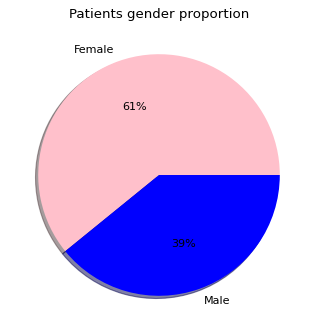

In [15]:
# Count frequencies and shows patients breakdown by stroke condition:
df_sex = pd.DataFrame(df8.groupby('Sex')['Sex'].count())
df_sex.columns = ['count']
plt.figure(figsize=(6,5), dpi= 80)
plt.pie(df_sex, labels=['Female','Male'], autopct='%.0f%%', colors=['pink','blue'], shadow=True)
plt.title('Patients gender proportion')
plt.show()

Text(0.5, 1.0, 'Age distribution')

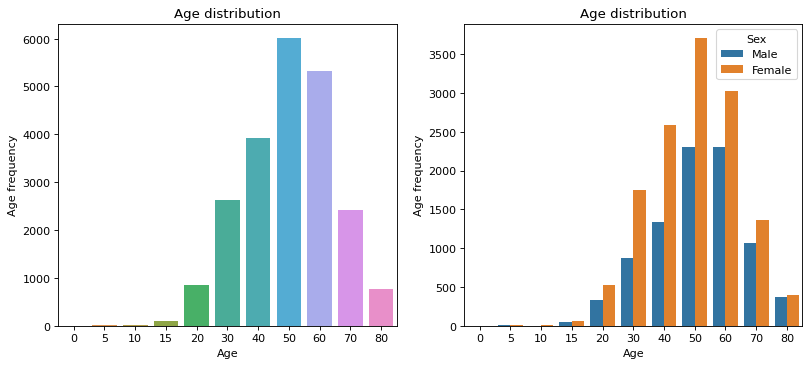

In [16]:
#visualize age distribution of the patient 
plt.figure(figsize=(12,5), dpi= 80)
plt.subplot(1, 2, 1)
sns.countplot(x="Age", data=df8,);
plt.ylabel('Age frequency')
plt.title('Age distribution')
plt.subplot(1, 2, 2)
sns.countplot(x="Age", hue="Sex",data=df8,);
plt.ylabel('Age frequency')
plt.title('Age distribution')
# plt.subplot(1, 3, 2)
# sns.countplot(x="Effectiveness", hue="Sex",data=df);
# plt.subplot(1, 3, 3)
# sns.countplot(x="Satisfaction", hue="Sex",data=df);

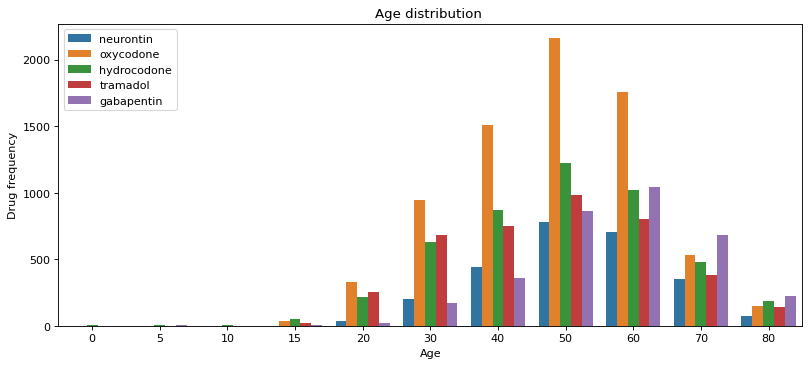

In [17]:
#The frequency of selected drugs across age.
plt.figure(figsize=(12,5), dpi= 80)

sns.countplot(x="Age", hue="Drug",data=df8,);
plt.ylabel('Drug frequency')
plt.title('Age distribution ')
plt.legend(loc='upper left')

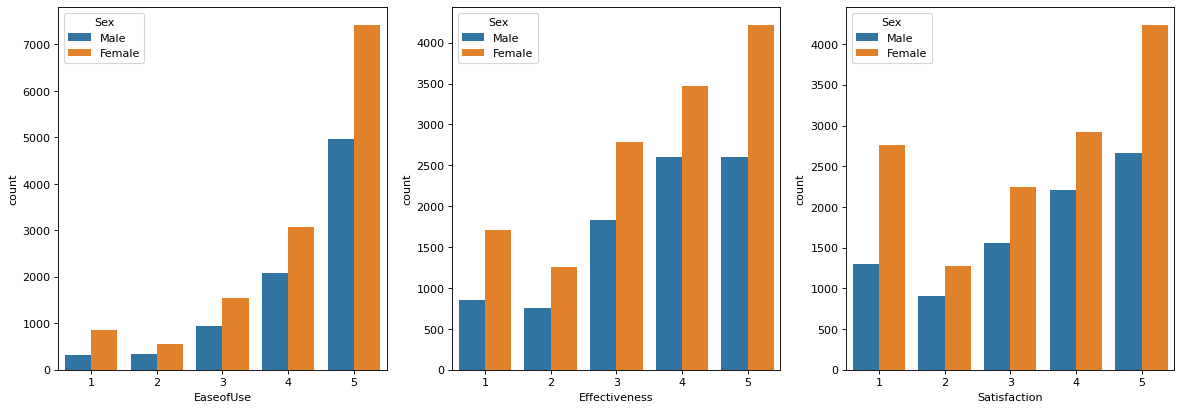

In [18]:
plt.figure(figsize=(18,6), dpi= 80)
plt.subplot(1, 3, 1)
sns.countplot(x="EaseofUse", hue="Sex",data=df8,);
plt.subplot(1, 3, 2)
sns.countplot(x="Effectiveness", hue="Sex",data=df8);
plt.subplot(1, 3, 3)
sns.countplot(x="Satisfaction", hue="Sex",data=df8);

Text(0.5, 1.0, 'Frequency of Drug')

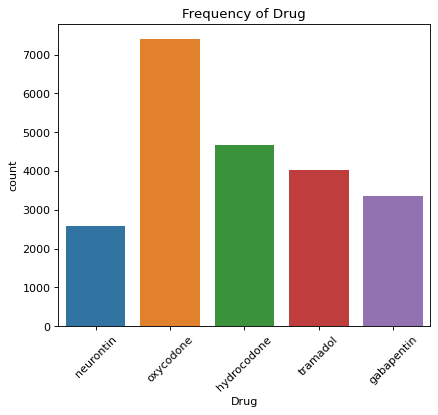

In [19]:
plt.figure(figsize=(6,5), dpi= 80)
av=sns.countplot(x="Drug", data=df8,);
av.set_xticklabels(av.get_xticklabels(), rotation=45);
av.set_title('Frequency of Drug')


In [20]:
df_mean=df8.groupby('Age').mean()
df_mean

,EaseofUse,Effectiveness,Satisfaction
Age,,,
0,3.333333,3.333333,3.333333
5,3.200000,3.500000,3.300000
10,3.857143,3.714286,3.714286
15,4.300000,3.890909,3.672727
20,4.218203,3.745624,3.494749
30,4.215567,3.628005,3.426936
40,4.208769,3.628855,3.448381
50,4.182529,3.547754,3.373544
60,4.240713,3.559850,3.381614


<Figure size 480x400 with 0 Axes>

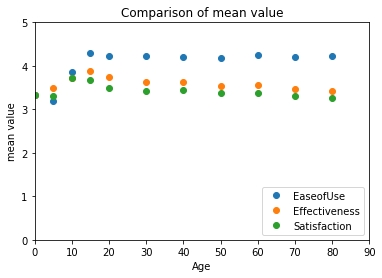

In [21]:
plt.figure(figsize=(6,5), dpi= 80)
df_mean.plot(style='o')
# Plot formatting
plt.xlabel('Age')
plt.ylabel('mean value')
plt.xlim(0,90)
plt.ylim(0,5)
plt.title('Comparison of mean value')
plt.legend(loc='lower right')

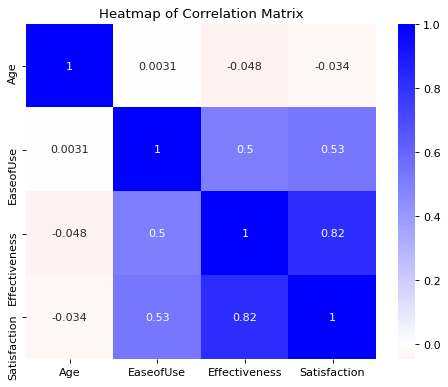

In [22]:
#graphical representation of corellation
plt.figure(figsize=(6,5), dpi= 80)
hm=sns.heatmap(df8.corr(), annot=True,center = 0,cmap='bwr_r', cbar=True)
plt.title('Heatmap of Correlation Matrix')
plt.tight_layout()

## Balancing classes

In [23]:
# Filter dataframe by a target label
df_hyd=df8[df8['Drug']=='hydrocodone']
df_oxy=df8[df8['Drug']=='oxycodone']
df_neu=df8[df8['Drug']=='neurontin']
df_gab=df8[df8['Drug']=='gabapentin']
df_trm=df8[df8['Drug']=='tramadol']
# Stratified by age_group_label of oxycodone drug:
df_oxy_grp1 = df_oxy[df_oxy['Age_group_label'] == 1] 
df_oxy_grp2 = df_oxy[df_oxy['Age_group_label'] == 2] 
df_oxy_grp3 = df_oxy[df_oxy['Age_group_label'] == 3] 
df_oxy_grp4 = df_oxy[df_oxy['Age_group_label'] == 4] 
df_oxy_grp5 = df_oxy[df_oxy['Age_group_label'] == 5] 
df_oxy_grp6 = df_oxy[df_oxy['Age_group_label'] == 6] 
df_oxy_grp7 = df_oxy[df_oxy['Age_group_label'] == 7] 

# Stratified by age_group_label of neurontin drug: 
df_neu_grp1 = df_neu[df_neu['Age_group_label'] == 1] 
df_neu_grp2 = df_neu[df_neu['Age_group_label'] == 2] 
df_neu_grp3 = df_neu[df_neu['Age_group_label'] == 3] 
df_neu_grp4 = df_neu[df_neu['Age_group_label'] == 4] 
df_neu_grp5 = df_neu[df_neu['Age_group_label'] == 5] 
df_neu_grp6 = df_neu[df_neu['Age_group_label'] == 6] 
df_neu_grp7 = df_neu[df_neu['Age_group_label'] == 7] 

# Stratified by age_group_label of gabapentin drug:
df_gab_grp1 = df_gab[df_gab['Age_group_label'] == 1]  
df_gab_grp2 = df_gab[df_gab['Age_group_label'] == 2] 
df_gab_grp3 = df_gab[df_gab['Age_group_label'] == 3] 
df_gab_grp4 = df_gab[df_gab['Age_group_label'] == 4] 
df_gab_grp5 = df_gab[df_gab['Age_group_label'] == 5] 
df_gab_grp6 = df_gab[df_gab['Age_group_label'] == 6] 
df_gab_grp7 = df_gab[df_gab['Age_group_label'] == 7] 

# Stratified by age_group_label of tramadol drug:
df_trm_grp1 = df_trm[df_trm['Age_group_label'] == 1]  
df_trm_grp2 = df_trm[df_trm['Age_group_label'] == 2] 
df_trm_grp3 = df_trm[df_trm['Age_group_label'] == 3] 
df_trm_grp4 = df_trm[df_trm['Age_group_label'] == 4] 
df_trm_grp5 = df_trm[df_trm['Age_group_label'] == 5] 
df_trm_grp6 = df_trm[df_trm['Age_group_label'] == 6] 
df_trm_grp7 = df_trm[df_trm['Age_group_label'] == 7] 
# Age group counts index for stratification by major class "drug" %:
df_hyd_counts = df_hyd[['Age_group','Age_group_label']]
df_hyd_counts = pd.DataFrame(df_hyd_counts.groupby('Age_group_label')['Age_group'].count())
df_hyd_counts.columns = ['counts']

# Compute age group label proporiton % on hydrocodone drug:
df_hyd_counts['Age_group_pct'] = df_hyd_counts['counts']/df_hyd_counts['counts'].sum()

# Print the count index for each age group from hydrocodone drug:
print(df_hyd_counts)

                 counts  Age_group_pct
Age_group_label                       
1                   268       0.057289
2                   628       0.134245
3                   867       0.185336
4                  1222       0.261223
5                  1023       0.218683
6                   482       0.103035
7                   188       0.040188


In [24]:
# downsampling on hydrocodone drug by oxycodone drug proporition %

sampled_oxy_grp1 = resample(df_oxy_grp1, replace=True, n_samples=270,random_state=0)
sampled_oxy_grp2 = resample(df_oxy_grp2, replace=True, n_samples=630,random_state=0)
sampled_oxy_grp3 = resample(df_oxy_grp3, replace=True, n_samples=870,random_state=0)
sampled_oxy_grp4 = resample(df_oxy_grp4, replace=True, n_samples=1225,random_state=0)
sampled_oxy_grp5 = resample(df_oxy_grp5, replace=True, n_samples=1025,random_state=0)
sampled_oxy_grp6 = resample(df_oxy_grp6, replace=True, n_samples=480,random_state=0)
sampled_oxy_grp7 = resample(df_oxy_grp7, replace=True, n_samples=190,random_state=0)

# Concatentate downsampled majority class: "oxycodone" drug of all age groups
df_oxy_downsampled = pd.concat([sampled_oxy_grp1,sampled_oxy_grp2,sampled_oxy_grp3, sampled_oxy_grp4,sampled_oxy_grp5,sampled_oxy_grp6,
                              sampled_oxy_grp7], axis=0)

In [26]:
# Upsampling on hydrocodone drug by neurontin drug proporition %

sampled_neu_grp1 = resample(df_neu_grp1, replace=True, n_samples=265,random_state=0)
sampled_neu_grp2 = resample(df_neu_grp2, replace=True, n_samples=630,random_state=0)
sampled_neu_grp3 = resample(df_neu_grp3, replace=True, n_samples=870,random_state=0)
sampled_neu_grp4 = resample(df_neu_grp4, replace=True, n_samples=1225,random_state=0)
sampled_neu_grp5 = resample(df_neu_grp5, replace=True, n_samples=1020,random_state=0)
sampled_neu_grp6 = resample(df_neu_grp6, replace=True, n_samples=480,random_state=0)
sampled_neu_grp7 = resample(df_neu_grp7, replace=True, n_samples=190,random_state=0)

# Concatentate upsampled minority class: "neurontin" drug of all age groups
df_neu_upsampled = pd.concat([sampled_neu_grp1,sampled_neu_grp2,sampled_neu_grp3, sampled_neu_grp4,sampled_neu_grp5,sampled_neu_grp6,
                               sampled_neu_grp7], axis=0)

In [27]:
# Upsampling on hydrocodone drug by gabapentin drug proporition %

sampled_trm_grp1 = resample(df_trm_grp1, replace=True, n_samples=265,random_state=0)
sampled_trm_grp2 = resample(df_trm_grp2, replace=True, n_samples=630,random_state=0)
sampled_trm_grp3 = resample(df_trm_grp3, replace=True, n_samples=870,random_state=0)
sampled_trm_grp4 = resample(df_trm_grp4, replace=True, n_samples=1225,random_state=0)
sampled_trm_grp5 = resample(df_trm_grp5, replace=True, n_samples=1025,random_state=0)
sampled_trm_grp6 = resample(df_trm_grp6, replace=True, n_samples=480,random_state=0)
sampled_trm_grp7 = resample(df_trm_grp7, replace=True, n_samples=190,random_state=0)

# Concatentate upsampled minority class: "gabapentin" drug of all age groups
df_trm_upsampled = pd.concat([sampled_trm_grp1,sampled_trm_grp2,sampled_trm_grp3, sampled_trm_grp4,sampled_trm_grp5,sampled_trm_grp6,
                               sampled_trm_grp7], axis=0)

In [28]:
# Upsampling on hydrocodone drug by tramadol drug proporition %

sampled_gab_grp1 = resample(df_gab_grp1, replace=True, n_samples=265,random_state=0)
sampled_gab_grp2 = resample(df_gab_grp2, replace=True, n_samples=630,random_state=0)
sampled_gab_grp3 = resample(df_gab_grp3, replace=True, n_samples=8370,random_state=0)
sampled_gab_grp4 = resample(df_gab_grp4, replace=True, n_samples=1225,random_state=0)
sampled_gab_grp5 = resample(df_gab_grp5, replace=True, n_samples=1020,random_state=0)
sampled_gab_grp6 = resample(df_gab_grp6, replace=True, n_samples=480,random_state=0)
sampled_gab_grp7 = resample(df_gab_grp7, replace=True, n_samples=190,random_state=0)

# Concatentate upsampled minority class: "tramadol" drug of all age groups
df_gab_upsampled = pd.concat([sampled_gab_grp1,sampled_gab_grp2,sampled_gab_grp3, sampled_gab_grp4,sampled_gab_grp5,sampled_gab_grp6,
                              sampled_gab_grp7], axis=0)

# Conbine downsampled majority class: "oxycodone" and upsampled minority classes: "gabapentin,neurontin,tramadol" 
# drug with unsampled hydrocodone drug
df9 = pd.concat([df_oxy_downsampled,df_neu_upsampled,df_trm_upsampled,df_gab_upsampled,df_hyd],axis=0)

In [29]:
#reset index
df9.reset_index(drop=True, inplace=True)
#pickle dataframe for later use
df9.to_pickle("Neuropathic Pain.pkl")
#Let's see the first 5 rows
df9.head()

,Age,Condition,Drug,EaseofUse,Effectiveness,Satisfaction,Sex,Age_group,Age_group_label
0,20,Pain,oxycodone,5,5,5,Male,"(0, 20]",1
1,20,Pain,oxycodone,5,4,4,Male,"(0, 20]",1
2,20,Pain,oxycodone,5,5,1,Male,"(0, 20]",1
3,20,Pain,oxycodone,1,1,1,Female,"(0, 20]",1
4,20,Pain,oxycodone,5,5,5,Female,"(0, 20]",1


In [30]:
import pickle
path='/content/Neuropathic Pain.pkl'
df9=pd.read_pickle(path)
df9.head()

,Age,Condition,Drug,EaseofUse,Effectiveness,Satisfaction,Sex,Age_group,Age_group_label
0,20,Pain,oxycodone,5,5,5,Male,"(0, 20]",1
1,20,Pain,oxycodone,5,4,4,Male,"(0, 20]",1
2,20,Pain,oxycodone,5,5,1,Male,"(0, 20]",1
3,20,Pain,oxycodone,1,1,1,Female,"(0, 20]",1
4,20,Pain,oxycodone,5,5,5,Female,"(0, 20]",1


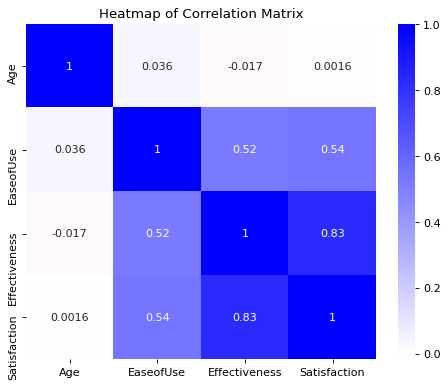

In [31]:
#graphical representation of corellation
plt.figure(figsize=(6,5), dpi= 80)
hm=sns.heatmap(df9 .corr(), annot=True,center = 0,cmap='bwr_r', cbar=True)
plt.title('Heatmap of Correlation Matrix')
plt.tight_layout()

# Statistical Test

#### Impact of EaseofUse and Satisfaction

Paired sampled t-test :- The paired sample t-test is also called dependent sample t-test. It’s an uni variate test that tests for a significant difference between 2 related variables.

Hypothesis Testing:  Is there a significant difference between the patient's response towards EaseofUse and Satisfaction?

##### Null  Hypothesis: 
\begin{array}{c}
H_0: \rho_{EaseofUse} = \rho_{Satisfaction}
\end{array}

The null hypothesis would be that there is no difference in patients response of EaseofUse and Satisfaction:

##### Alternate Hypothesis:  
\begin{array}{c}
H_A: \rho_{EaseofUse} \neq \rho_{Satisfaction}
\end{array}


The alternative hypothesis would be that there is a difference in patients response of EaseofUse and Satisfaction.

In oder to test this hypothesis, we conducted t-test using ttest_ind()

In [32]:
from scipy.stats import ttest_ind
from scipy import stats
ttest,pval = stats.ttest_ind(df9['EaseofUse'], df9['Satisfaction'])
print(ttest,pval)
if pval < 0.05:
    print("fail to accepet null hypothesis")
else:
    print("accept null hypothesis")

79.90737947210577 0.0
fail to accepet null hypothesis


#### Impact of Effectiveness and Satisfaction

Hypothesis Testing:  Is there significant difference between the patients response towards Effectiveness and Satisfaction?


##### Null  Hypothesis: 
\begin{array}{c}
H_0: \rho_{Effectiveness} = \rho_{Satisfaction}
\end{array}

The null hypothesis would be that there is no difference in patients response of Effectiveness and Satisfaction:

##### Alternate Hypothesis:  
\begin{array}{c}
H_A: \rho_{Effectiveness} \neq \rho_{Satisfaction}
\end{array}

The alternative hypothesis would be that there is a difference in patients response of Effectiveness and Satisfaction.

In oder to test this hypothesis, we conducted t-test using ttest_ind()

In [33]:
from scipy.stats import ttest_ind
from scipy import stats
ttest,pval = stats.ttest_ind(df9['Effectiveness'], df9['Satisfaction'])
print(ttest,pval)
if pval < 0.05:
    print("fail to accept null hypothesis")
else:
    print("accept null hypothesis")

18.644628052793802 2.278111779704571e-77
fail to accept null hypothesis


#### Impact of EaseofUse and Effectiveness

Hypothesis Testing:  Is there significant difference between the patients response towards EaseofUse and Effectiveness?


##### Null  Hypothesis: 
\begin{array}{c}
H_0: \rho_{EaseofUse} = \rho_{Effectiveness}
\end{array}

The null hypothesis would be that there is no difference in patients response of EaseofUse and Effectiveness:

##### Alternate Hypothesis:  
\begin{array}{c}
H_A: \rho_{EaseofUse} \neq \rho_{Effectiveness}
\end{array}

The alternative hypothesis would be that there is a difference in patients response of EaseofUse and Effectiveness.

In oder to test this hypothesis, we conducted t-test using ttest_ind()

In [34]:
from scipy.stats import ttest_ind
from scipy import stats
ttest,pval = stats.ttest_ind(df9['EaseofUse'], df9['Effectiveness'])
print(ttest,pval)
if pval < 0.05:
  print("fail to accept null hypothesis")
else:
  print("accept null hypothesis")

64.69098599398261 0.0
fail to accept null hypothesis


#### Impact of Age and Satisfaction

Hypothesis Testing:  Is there a significant difference between the patient's Satisfaction depending on their age?


##### Null  Hypothesis: 
\begin{array}{c}
H_0: \rho_{Age} = \rho_{Satisfaction}
\end{array}

The null hypothesis would be that there is no difference in patients response of Age and Satisfaction:

##### Alternate Hypothesis:  
\begin{array}{c}
H_A: \rho_{Age} \neq \rho_{Satisfaction}
\end{array}

The alternative hypothesis would be that there is a difference in patients response of Age and Satisfaction.

In oder to test this hypothesis, we conducted t-test using ttest_ind()

In [35]:
from scipy.stats import ttest_ind
from scipy import stats
ttest,pval = stats.ttest_ind(df9['Age'], df9['Satisfaction'])
print(ttest,pval)
if pval < 0.05:
  print("fail to accept null hypothesis")
else:
  print("accept null hypothesis")

557.9792331967918 0.0
fail to accept null hypothesis


### Multicollinearity
Multicollinearity refers to predictors that are correlated with other predictors. Multicollinearity occurs when model includes multiple factors that are correlated not just to the response variable, but also to each other. In other words, it results when we have factors that are a bit redundant. Sklearn does not have a built-in way to check for multicollinearity


In [36]:
# Here's the relevant module
from statsmodels.stats.outliers_influence import variance_inflation_factor

# To make this as easy as possible to use, we declare a variable where we put
# all features where we want to check for multicollinearity
# since our categorical data is not yet preprocessed, we will only take the numerical ones
variables = df9[['Age','EaseofUse','Effectiveness','Satisfaction']]

# we create a new data frame which will include all the VIFs
# note that each variable has its own variance inflation factor as this measure is variable specific (not model specific)
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
# Finally, I like to include names so it is easier to explore the result
vif["Features"] = variables.columns
vif

,VIF,Features
0,7.277050,Age
1,15.196056,EaseofUse
2,23.901570,Effectiveness
3,18.684840,Satisfaction


Looking at the result of variance inflation factor, all numerical features have high multicolinearity. However, the VIF of Effectiveness is highest, so we will remove it from the model.

In [37]:
#drop effectiveness
df10 = df9.drop(['Effectiveness'],axis=1)
#display new dataframe
df10.head()

,Age,Condition,Drug,EaseofUse,Satisfaction,Sex,Age_group,Age_group_label
0,20,Pain,oxycodone,5,5,Male,"(0, 20]",1
1,20,Pain,oxycodone,5,4,Male,"(0, 20]",1
2,20,Pain,oxycodone,5,1,Male,"(0, 20]",1
3,20,Pain,oxycodone,1,1,Female,"(0, 20]",1
4,20,Pain,oxycodone,5,5,Female,"(0, 20]",1


# **MACHINE LEARNING MODELING**

## Create dummy variable
To include the categorical data in the regression, let's create dummy variable encoding on nominal features using a very 'convenient method called: get_dummies' which does that seemlessly. It is extremely important that we drop one of the dummies, alternatively will introduce multicollinearity.

In [44]:
df11 = pd.get_dummies(df10[['Condition','Age','EaseofUse','Satisfaction','Sex']], drop_first=True)

# Concatenated with a Drug label on transformed dataframe: 
df = pd.concat([df11, df10['Drug']], axis=1)

## Split input features and output label
Using split_train_test function partition original data into training and test sets for training and evaluation of any machine learning modeling task.  
After partitioning the data, we feature scale, the features to re-scale them into a similar range on each feature using scaler function.


In [45]:
#Split train and test
X=df.drop('Drug', axis=1)
#Feature Scaling
scaler=StandardScaler()
X=scaler.fit_transform(X)

y=df['Drug']
#encoding the categical classes using label encoder
lab_enc = preprocessing.LabelEncoder()
y=lab_enc.fit_transform(y)
y = y.astype(np.int)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25,stratify=y)

## **Data Modeling**

We modeled the data using different classification: Decission Tree, Random Forest, Gradient Boosting, XGBoosting, Extra tree and KNeighbors classifiers and the best model performance out of six will be selected.  

#### Tune Hyperparameters for Classification
Machine learning algorithms have hyperparameters that allow us to tailor the behavior of the algorithm to your specific dataset. In order to find out the best hyperparameters, we modeled cross-validation on the training dataset and create hyperparameter options then selected the best hyperparameter.

### Logistic Regression
Logistic regression works by using a logit function to transform input value of features and calculate estimated probabilities of a label in range of [0,1].

In [40]:
# Model: Logistic Regression
lr_cv = LogisticRegression(C=0.1,penalty='l2',random_state=0)
lr_cv.fit(X_train, y_train)

# RandomizedSearchCV: LogisticRegression #
# Create hyperparameter options:
param_dist = dict(C=randint(2,100), penalty=['l1','l2'])
random_search = RandomizedSearchCV(estimator=lr_cv, param_distributions=param_dist, random_state=0, n_iter=100, cv=4)
random_search_lr = random_search.fit(X_train, y_train)

# View best hyperparameters
print('Best Penalty:', random_search_lr.best_estimator_.get_params()['penalty'])
print('Best C:', random_search_lr.best_estimator_.get_params()['C'])


Best Penalty: l2
Best C: 46


In [46]:
lr= LogisticRegression(C=46,penalty='l2',random_state=0)
lr.fit(X_train, y_train)
y_lr_pred = lr.predict(X_test);

### Support vector machine

Support Vector Machine is used for both regression and classification tasks. In SVM algorithm is to find a hyperplane in an n-dimensional space(n: the number of features) that distinctly classifies the data points. Hyperplanes are decision boundaries that help classify the data points. 

In [ ]:
# Model: support vector machine
svm_cv = SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, 
                                 random_state=0)
svm_cv.fit(X_train, y_train)

# Hyperparameters Tuning: Create hyperparameter options
param_dist_svm = {"C": randint(1, 100),
                  "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
                  "gamma": ['scale', 'auto'],
                  "shrinking":[True, False],
                  }
random_search = RandomizedSearchCV(estimator=svm_cv, param_distributions=param_dist_svm, random_state=0, n_iter=100, cv=4)
random_search_svm = random_search.fit(X_train, y_train)

# View best hyperparameters
print('Best shrinking:', random_search_svm.best_estimator_.get_params()['shrinking'])
print('Best gamma:', random_search_svm.best_estimator_.get_params()['gamma'])
print('Best kernel:', random_search_svm.best_estimator_.get_params()['kernel'])
print('Best C:', random_search_svm.best_estimator_.get_params()['C'])

In [47]:
svm = SVC(C=94, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=False, tol=0.001, random_state=0)
svm.fit(X_train, y_train)
y_svm_pred = svm.predict(X_test);


### Decision Tree Classifier

Decision tree is a Supervised Machine Learning where the data is continuously split according to a certain parameter. Decision tree classifier: using the decision algorithm, we start at the tree root and split the data on the feature that results in the largest information gain (IG). In an iterative process, we can then repeat this splitting procedure at each child node until the leaves are pure.


In [ ]:
# Model: DecisionTree [cross-validated train set]
tree_cv = DecisionTreeClassifier(criterion='gini', max_depth=8, min_samples_split=2, min_samples_leaf=2, random_state=0)
tree_cv.fit(X_train, y_train)

# Hyperparameters Tuning: Create hyperparameter options
param_dist_dt = {"criterion": ["gini", "entropy"],
                  "max_depth": randint(10, 100),
                  "max_leaf_nodes": randint(10, 20),
                  "min_samples_split": randint(2, 10),
                  "min_samples_leaf": randint(2, 10)}
random_search = RandomizedSearchCV(estimator=tree_cv, param_distributions=param_dist_dt, random_state=0, n_iter=100, cv=4)
random_search_dt = random_search.fit(X_train, y_train)

# View best hyperparameters
print('Best min_samples_split:', random_search_dt.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', random_search_dt.best_estimator_.get_params()['min_samples_leaf'])
print('Best max_leaf_nodes:', random_search_dt.best_estimator_.get_params()['max_leaf_nodes'])
print('Best max_depth:', random_search_dt.best_estimator_.get_params()['max_depth'])
print('Best criterion:', random_search_dt.best_estimator_.get_params()['criterion'])

Best min_samples_split: 8
Best min_samples_leaf: 8
Best max_leaf_nodes: 19
Best max_depth: 83
Best criterion: gini


 1) Condition_Pain                 0.802243
 2) Age                            0.122440
 3) Condition_Pain from Nerve      0.043755
 4) Satisfaction                   0.022246
 5) Sex_Male                       0.008120
 6) EaseofUse                      0.001195


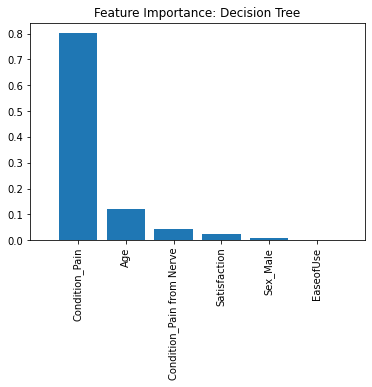

In [48]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=51, min_samples_split=8, min_samples_leaf=5, max_leaf_nodes=19,
                               random_state=0)
feat_labels = df.columns[:-1]
tree.fit(X_train, y_train)
y_tree_pred = tree.predict(X_test);
importances = tree.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 30,  feat_labels[indices[f]], importances[indices[f]]))

plt.title('Feature Importance: Decision Tree')
plt.bar(range(X_train.shape[1]), importances[indices],  align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim(-1, X_train.shape[1])
plt.show()

### Random Forest Classifier

random forest is comprised of trees that the more trees it has, the more robust a forest is. Random forests creates decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting. 




In [ ]:
# Model: RandomForest [cross-validated and train set]
rf_cv = RandomForestClassifier(criterion='gini',n_estimators=50, max_depth=1, min_samples_split=2, random_state=0, n_jobs=1)
rf_cv.fit(X_train, y_train)

# Hyperparameters Tuning: Create hyperparameter options
param_dist_rf = {"n_estimators": randint(20, 200), 
                 "max_depth": randint(10, 100),
                  "min_samples_split": randint(2, 10),
                  "min_samples_leaf": randint(2, 10),
                  "bootstrap": [True, False],
                  "criterion": ["gini", "entropy"]}
random_search = RandomizedSearchCV(estimator=rf_cv, param_distributions=param_dist_rf, random_state=0, n_iter=100, cv=4)
random_search_rf = random_search.fit(X_train, y_train)

# View best hyperparameters
print('Best n_estimators:', random_search_rf.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', random_search_rf.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', random_search_rf.best_estimator_.get_params()['min_samples_split'])
print('Best bootstrap:', random_search_rf.best_estimator_.get_params()['bootstrap'])
print('Best min_samples_leaf:', random_search_rf.best_estimator_.get_params()['min_samples_leaf'])

 1) Condition_Pain                 0.567410
 2) Age                            0.168198
 3) Condition_Pain from Nerve      0.125269
 4) Satisfaction                   0.064959
 5) EaseofUse                      0.056299
 6) Sex_Male                       0.017864


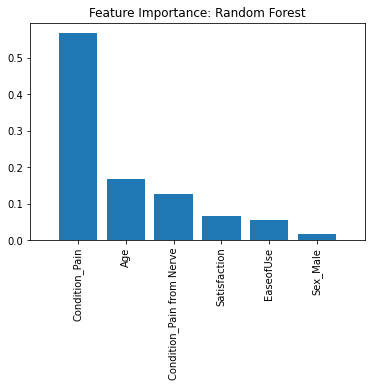

In [49]:
# Model prediction: Using a Random Forest:
rf = RandomForestClassifier(criterion='entropy', max_depth=33, min_samples_split=6, min_samples_leaf=2, n_estimators=120, 
                            bootstrap= True,random_state=0)
rf.fit(X_train, y_train)
y_rf_pred = rf.predict(X_test);
feat_labels = df.columns[:-1]
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

plt.figure()    
plt.title('Feature Importance: Random Forest')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim(-1, X_train.shape[1])
plt.show()

### KNeighbors Classifier
The KNN algorithm assumes that similar things exist in close proximity. It involves three steps: calculating the distance between points, finding the closest neighbors and voting for the labels.

In [50]:
knn = KNeighborsClassifier(3)
knn.fit(X_train, y_train)
y_knn_pred = knn.predict(X_test)
sk_report = classification_report(digits=3, y_true=y_test, y_pred=y_knn_pred)
print('KNeighborsClassifier Result')
print(sk_report)
print('roc_auc_score of KNeighborsClassifier is: '+str(roc_auc_score(y_test, y_knn_pred)))

KNeighborsClassifier Result
              precision    recall  f1-score   support

           0      0.758     0.892     0.819      3045
           1      0.404     0.529     0.458      1170
           2      0.585     0.454     0.511      1170
           3      0.384     0.242     0.297      1173
           4      0.381     0.315     0.345      1171

    accuracy                          0.585      7729
   macro avg      0.502     0.486     0.486      7729
weighted avg      0.564     0.585     0.567      7729



ValueError: ignored

In order to address the issue of the above error "ValueError: multiclass format is not supported" we converted the target class Label binarizer using the following function.

In [51]:
def multiclass_roc_auc_score(y_test,y_pred,average="macro"):
  lb = preprocessing.LabelBinarizer()
  lb.fit(y_test)
  y_test=lb.transform(y_test)
  y_pred=lb.transform(y_pred)
  return roc_auc_score(y_test,y_pred,average=average)

In [52]:
print('roc_auc_score of KNeighborsClassifier is: '+str(multiclass_roc_auc_score(y_test, y_knn_pred)))

roc_auc_score of KNeighborsClassifier is: 0.6889245671982072


Compare the accuracy the models so far.

In [53]:
names = ["Logistic Regression", "Support Vector Machine","Decision Tree", "Random Forest", "KNeighbors", ]

classifiers = [
    LogisticRegression(C=46,penalty='l2',random_state=0),
    SVC(C=94, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=False, tol=0.001, random_state=0),
    DecisionTreeClassifier(criterion='entropy', max_depth=51, min_samples_split=8, min_samples_leaf=5, max_leaf_nodes=19,
                               random_state=0),
    RandomForestClassifier(criterion='entropy', max_depth=33, min_samples_split=6, min_samples_leaf=2, n_estimators=120, 
                            bootstrap= True,random_state=0),
    KNeighborsClassifier(3)
    ]

res = []
res2 = []
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    res.append(clf.predict(X_test))
    temp = clf.predict(X_train)
    res2.append(temp)
    print(name, " : ", accuracy_score(y_train, temp))

Logistic Regression  :  0.5660499417777203
Support Vector Machine  :  0.6163367404148876
Decision Tree  :  0.5732522534178635
Random Forest  :  0.6433777547763834
KNeighbors  :  0.6005951610816406


Looking at the model accuracies above, Random Forest performs well compared to othe models (Logistic Regression, Support Vector Machine, Decision Tree and KNeighbors Classifier). Hence, let's explore more with an ensemble of decision trees and other related ensembles of decision trees algorithms. 

### Gradient Boosting Classifier
Gradient Boosting Classifiers are a group of machine learning algorithms that combine many weak learning models together to create a strong predictive model. The idea behind is to take a weak hypothesis or weak learning algorithm and make a series of tweaks to it that will improve the strength of the hypothesis/learner based on the idea of Probability Approximately Correct Learning (PAC).


 

In [ ]:
# Model: Gradient Boosting Classifier [cross-validated and train set]
gbc_cv = GradientBoostingClassifier(criterion='mse',n_estimators=50, max_depth=1, min_samples_split=2, random_state=0)
gbc_cv.fit(X_train, y_train)

# Hyperparameters Tuning: Create hyperparameter options
param_dist_gbc = {"n_estimators": randint(20, 200), 
                 "max_depth": randint(10, 100),
                 "min_samples_split": randint(2, 10),
                 "min_samples_leaf": randint(2, 10),
                 "criterion": ["friedman_mse", "mse", "mae"]}
random_search = RandomizedSearchCV(estimator=gbc_cv, param_distributions=param_dist_gbc, random_state=0, n_iter=100, cv=4)
random_search_gbc = random_search.fit(X_train, y_train)

# View best hyperparameters
print('Best n_estimators:', random_search_gbc.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', random_search_gbc.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', random_search_gbc.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', random_search_gbc.best_estimator_.get_params()['min_samples_leaf'])


 1) Condition_Pain                 0.614037
 2) Age                            0.196765
 3) Satisfaction                   0.072947
 4) EaseofUse                      0.060276
 5) Sex_Male                       0.031484
 6) Condition_Pain from Nerve      0.024490


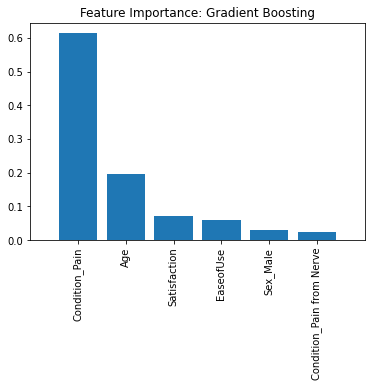

In [54]:
# Feature Selection: Using a Gradient Boosting Classifier:
gbc = GradientBoostingClassifier(criterion='mse', max_depth=89, min_samples_split=7, min_samples_leaf=9, n_estimators=159, 
                            random_state=0)
gbc.fit(X_train, y_train)
y_gbc_pred = gbc.predict(X_test)
feat_labels = df.columns[:-1]
importances = gbc.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

plt.figure()    
plt.title('Feature Importance: Gradient Boosting')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim(-1, X_train.shape[1])
plt.show()

### XGBoost Classifier
XGBoost (eXtreme Gradient Boosting) is an advanced implementation of gradient boosting algorithm designed to be highly efficient, flexible and portable.

In [ ]:
# Model: XGBClassifier [cross-validated and standardization of train set]
xgb_cv = XGBClassifier(n_estimators=50, learning_rate=0.2, max_depth=1, random_state=0, n_jobs=1)
xgb_cv.fit(X_train, y_train)

# Hyperparameters Tuning: Create hyperparameter options:
param_dist_xgb = {"n_estimators": randint(20, 200), 
                 "max_depth": randint(10, 100),
                  "learning_rate": np.random.uniform(0,1,10),
                  "objective": ['binary:logistic','reg:linear'],
                  "booster": ['gbtree','gblinear']}
random_search = RandomizedSearchCV(estimator=xgb_cv, param_distributions=param_dist_xgb,
                                   random_state=0, n_iter=100, cv=4)
random_search_xgb = random_search.fit(X_train, y_train)

# View best hyperparameters
print('Best n_estimators:', random_search_xgb.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', random_search_xgb.best_estimator_.get_params()['max_depth'])
print('Best learning_rate:', random_search_xgb.best_estimator_.get_params()['learning_rate'])
print('Best objective:', random_search_xgb.best_estimator_.get_params()['objective'])
print('Best booster:', random_search_xgb.best_estimator_.get_params()['booster'])


Best n_estimators: 63
Best max_depth: 45
Best learning_rate: 0.9707161877673031
Best objective: multi:softprob
Best booster: gbtree


 1) Condition_Pain                 0.893062
 2) Condition_Pain from Nerve      0.051570
 3) Age                            0.026184
 4) Satisfaction                   0.010650
 5) EaseofUse                      0.010372
 6) Sex_Male                       0.008162


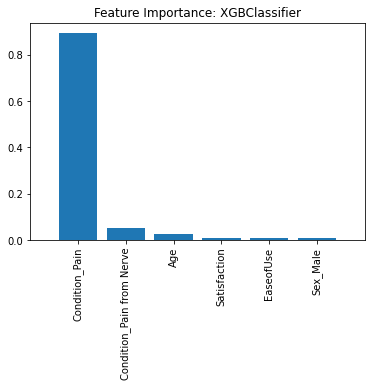

In [55]:
# Model prediction using a XGBClassifier: hold-out test set:  
xgb = XGBClassifier(n_estimators=63, learning_rate=0.97, max_depth=45, objective="multi:softprob",  random_state=0)
xgb.fit(X_train, y_train)
y_xgb_pred = xgb.predict(X_test)
feat_labels = df.columns[:-1]
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

plt.figure()    
plt.title('Feature Importance: XGBClassifier')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim(-1, X_train.shape[1])
plt.show()

### Extra Trees Classifier
The predictions of the trees are aggregated to yield the final prediction, by majority vote in classification problems and arithmetic average in regression problems.


In [ ]:
# Model: XGBClassifier [cross-validated and standardization of train set]
etc_cv = ExtraTreesClassifier(n_estimators=50, criterion='gini', max_depth=1, random_state=0, n_jobs=1)
etc_cv.fit(X_train, y_train)

# Hyperparameters Tuning: Create hyperparameter options:
param_dist_etc = {"n_estimators": randint(20, 200), 
                 "max_depth": randint(10, 100),
                  "min_samples_split": randint(2, 10),
                  "min_samples_leaf": randint(2, 10),
                  "criterion": ['gini', 'entropy'],
                  "bootstrap": ['True','False']}
random_search = RandomizedSearchCV(estimator=etc_cv, param_distributions=param_dist_etc,
                                   random_state=0, n_iter=100, cv=4)
random_search_etc = random_search.fit(X_train, y_train)

# View best hyperparameters
print('Best n_estimators:', random_search_etc.best_estimator_.get_params()['n_estimators'])
print('Best max_depth:', random_search_etc.best_estimator_.get_params()['max_depth'])
print('Best criterion:', random_search_etc.best_estimator_.get_params()['criterion'])
print('Best min_samples_split:', random_search_etc.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', random_search_etc.best_estimator_.get_params()['min_samples_leaf'])


 1) Condition_Pain                 0.641565
 2) Age                            0.132861
 3) Condition_Pain from Nerve      0.132197
 4) Satisfaction                   0.045557
 5) EaseofUse                      0.032631
 6) Sex_Male                       0.015189


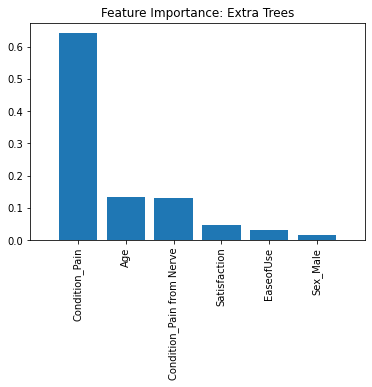

In [56]:
# Feature Selection: Using a Extra Trees Classifier:
etc = ExtraTreesClassifier(n_estimators=72, max_depth=55, criterion= 'entropy', min_samples_split=7, min_samples_leaf=9,random_state=0)
etc.fit(X_train, y_train)
y_etc_pred = etc.predict(X_test)
feat_labels = df.columns[:-1]
importances = etc.feature_importances_
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

plt.figure()    
plt.title('Feature Importance: Extra Trees')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), feat_labels[indices], rotation=90)
plt.xlim(-1, X_train.shape[1])
plt.show()

### Bagging Classifier
In bagging classifier the algorithm builds multiple models from randomly taken subsets of train dataset and aggregates learners to build overall stronger learner.

In [ ]:
# Model: XGBClassifier [cross-validated and standardization of train set]
bag_cv = BaggingClassifier(n_estimators=50, max_samples=1.0, max_features=1.0, random_state=0, n_jobs=1)
bag_cv.fit(X_train, y_train)

# Hyperparameters Tuning: Create hyperparameter options:
param_dist_bag = {"n_estimators": randint(20, 200), 
                 "max_features": randint(1, 100),
                  "max_samples": randint(1, 10),
                  "bootstrap":[True, False]
                  }
random_search = RandomizedSearchCV(estimator=bag_cv, param_distributions=param_dist_bag,
                                   random_state=0, n_iter=100, cv=4)
random_search_bag = random_search.fit(X_train, y_train)

# View best hyperparameters
print('Best n_estimators:', random_search_bag.best_estimator_.get_params()['n_estimators'])
print('Best max_features:', random_search_bag.best_estimator_.get_params()['max_features'])
print('Best max_samples:', random_search_bag.best_estimator_.get_params()['max_samples'])
print('Best bootstrap:', random_search_bag.best_estimator_.get_params()['bootstrap'])


In [57]:
bag =  BaggingClassifier(n_estimators=83,  max_features=1.0, random_state=0, bootstrap= True)
bag.fit(X_train, y_train)
y_bag_pred = bag.predict(X_test)
sk_report = classification_report(digits=3, y_true=y_test, y_pred=y_bag_pred)
print('BaggingClassifier Result')
print(sk_report)
print('roc_auc_score of BaggingClassifier is: '+str(multiclass_roc_auc_score(y_test, y_bag_pred)))

BaggingClassifier Result
              precision    recall  f1-score   support

           0      0.792     0.881     0.834      3045
           1      0.427     0.599     0.499      1170
           2      0.569     0.583     0.576      1170
           3      0.435     0.302     0.356      1173
           4      0.516     0.303     0.382      1171

    accuracy                          0.618      7729
   macro avg      0.548     0.534     0.529      7729
weighted avg      0.607     0.618     0.603      7729

roc_auc_score of BaggingClassifier is: 0.717419718880011


## Majority Vote Classifier (Ensemble Learning)

In [58]:
names = ["LogisticRegression","Support Vector Machine","Decision Tree", "Random Forest", "Gradient Boosting", "XGBoost", "Extra Tree", "KNeighbors", "Bagging"]

classifiers = [
     LogisticRegression(C=46,penalty='l2',random_state=0),          
    SVC(C=94, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, probability=False, tol=0.001, random_state=0),
    DecisionTreeClassifier(criterion='entropy', max_depth=51, min_samples_split=8, min_samples_leaf=5, max_leaf_nodes=19,
                               random_state=0),
    RandomForestClassifier(criterion='entropy', max_depth=33, min_samples_split=6, min_samples_leaf=2, n_estimators=120, 
                            bootstrap= True,random_state=0),
    KNeighborsClassifier(3),
    GradientBoostingClassifier(criterion='mse', max_depth=89, min_samples_split=7, min_samples_leaf=9, n_estimators=159, 
                            random_state=0),
    XGBClassifier(n_estimators=107, learning_rate=0.33, max_depth=49, objective="multi:softprob",  random_state=0),
    ExtraTreesClassifier(n_estimators=72, max_depth=55, criterion= 'entropy', min_samples_split=7, min_samples_leaf=9,random_state=0),
    BaggingClassifier(n_estimators=83,  max_features=1.0, random_state=0, bootstrap= True)
    ]

res = []
res2 = []
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    res.append(clf.predict(X_test))
    temp = clf.predict(X_train)
    res2.append(temp)
    print(name, " accuracy is : ", accuracy_score(y_train, temp))
    
    

LogisticRegression  accuracy is :  0.5660499417777203
Support Vector Machine  accuracy is :  0.6163367404148876
Decision Tree  accuracy is :  0.5732522534178635
Random Forest  accuracy is :  0.6433777547763834
Gradient Boosting  accuracy is :  0.6005951610816406
XGBoost  accuracy is :  0.6441109242247811
Extra Tree  accuracy is :  0.6441109242247811
KNeighbors  accuracy is :  0.6318626816750765
Bagging  accuracy is :  0.6440246689955579


# Evaluation of Model using Confusion Matrix
Confusion matix is one of the methods to evaluate the performance of a classifies and it a tabular summay of classifiers with their corresponding number of correct and incorrrect predictions. 
Since we already knew the accuracy of each model, we'll draw the confusion matrix of selected models.

In [60]:
#Confussion matrix plotting function
def plot_cm (cm, classes):
  fig, ax = plt.subplots(figsize=(10,10))
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=class_labels, yticklabels=class_labels)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')   
    
class_labels=np.array(['gabapentin','hydrocodone','neurontin','oxycodone','tramadol'],dtype=str)

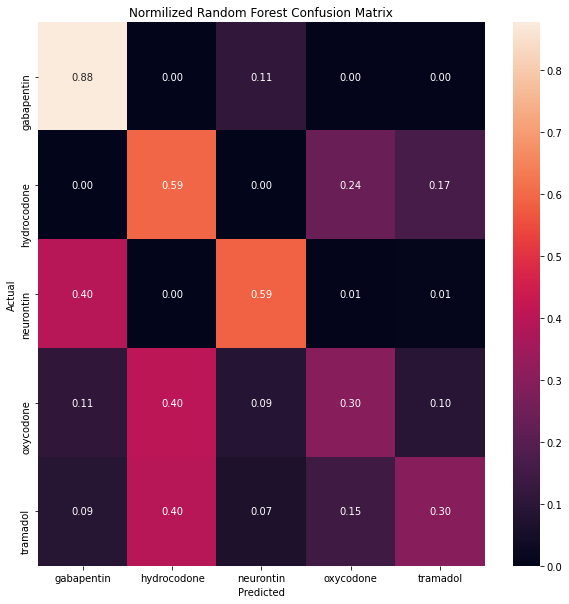

Random Forest Result
              precision    recall  f1-score   support

  gabapentin      0.792     0.877     0.833      3045
 hydrocodone      0.426     0.595     0.496      1170
   neurontin      0.564     0.588     0.576      1170
   oxycodone      0.430     0.300     0.353      1173
    tramadol      0.515     0.301     0.380      1171

    accuracy                          0.616      7729
   macro avg      0.546     0.532     0.528      7729
weighted avg      0.605     0.616     0.602      7729

ROC score of Random Forest is 0.72


In [61]:
# Confusion matrix of Random Forest
cm=confusion_matrix(y_test, y_rf_pred)
plot_cm(cm, class_labels)
plt.title('Normilized Random Forest Confusion Matrix')
plt.show()
sk_report = classification_report(digits=3, y_true=y_test, y_pred=y_rf_pred,target_names=class_labels)
print('Random Forest Result')
print(sk_report)
print('ROC score of Random Forest is %0.2f'% (multiclass_roc_auc_score(y_test, y_rf_pred)))


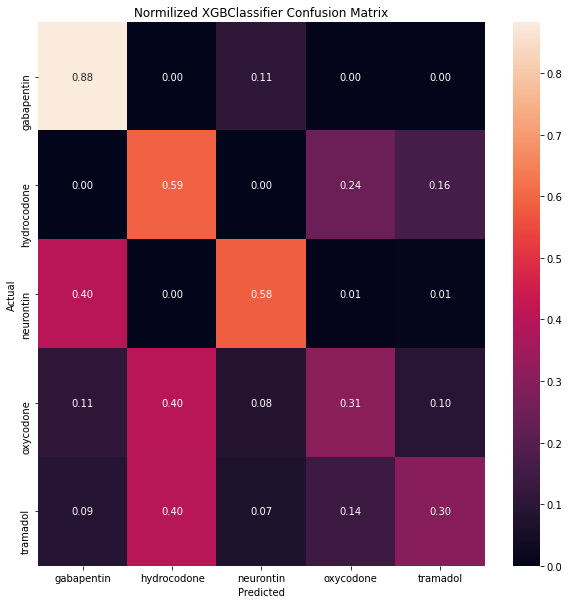

XGBClassifier Result
              precision    recall  f1-score   support

  gabapentin      0.792     0.883     0.835      3045
 hydrocodone      0.425     0.592     0.495      1170
   neurontin      0.573     0.585     0.579      1170
   oxycodone      0.431     0.305     0.357      1173
    tramadol      0.517     0.301     0.381      1171

    accuracy                          0.618      7729
   macro avg      0.548     0.533     0.529      7729
weighted avg      0.607     0.618     0.604      7729

ROC score of XGBClassifier is 0.72


In [62]:
# Confusion matrix of XGBClassifier
cm=confusion_matrix(y_test, y_xgb_pred)
plot_cm(cm, class_labels)
plt.title('Normilized XGBClassifier Confusion Matrix')
plt.show()
sk_report = classification_report(digits=3, y_true=y_test, y_pred=y_xgb_pred,target_names=class_labels)
print('XGBClassifier Result')
print(sk_report)
print('ROC score of XGBClassifier is %0.2f'% (multiclass_roc_auc_score(y_test, y_xgb_pred)))


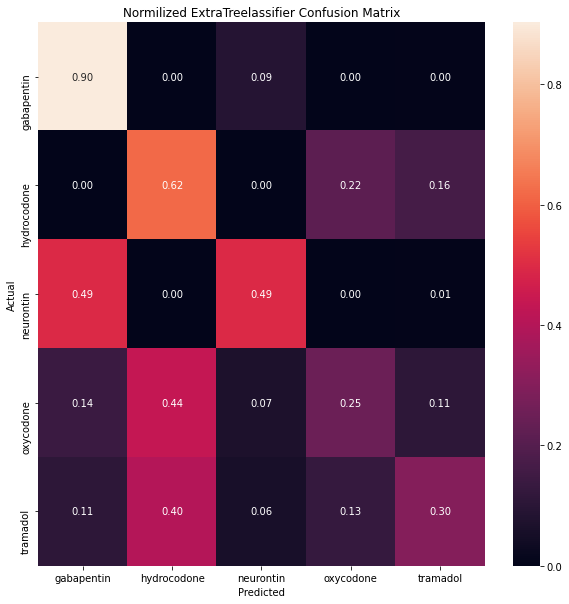

ExtraTreelassifier Result
              precision    recall  f1-score   support

  gabapentin      0.760     0.903     0.825      3045
 hydrocodone      0.424     0.618     0.503      1170
   neurontin      0.579     0.495     0.534      1170
   oxycodone      0.412     0.249     0.310      1173
    tramadol      0.512     0.302     0.380      1171

    accuracy                          0.608      7729
   macro avg      0.537     0.514     0.510      7729
weighted avg      0.591     0.608     0.587      7729

ROC score of ExtraTreelassifier is 0.71


In [66]:
# Confusion matrix of ExtraTreelassifier
cm=confusion_matrix(y_test, y_etc_pred)
plot_cm(cm, class_labels)
plt.title('Normilized ExtraTreelassifier Confusion Matrix')
plt.show()
sk_report = classification_report(digits=3, y_true=y_test, y_pred=y_etc_pred,target_names=class_labels)
print('ExtraTreelassifier Result')
print(sk_report)
print('ROC score of ExtraTreelassifier is %0.2f'% (multiclass_roc_auc_score(y_test, y_etc_pred)))


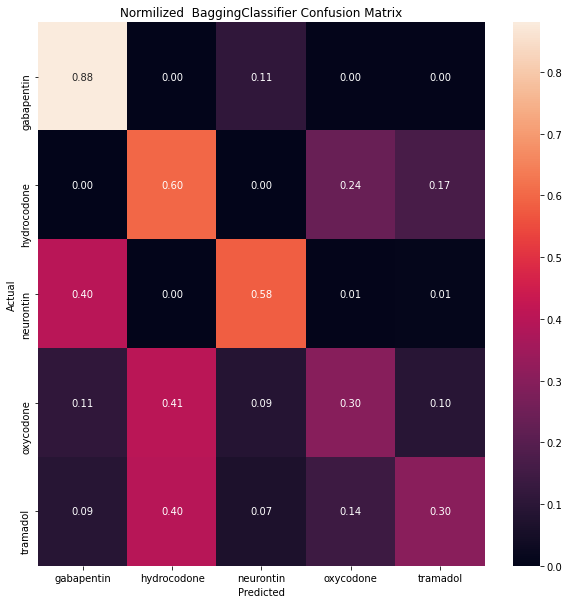

 BaggingClassifier Result
              precision    recall  f1-score   support

  gabapentin      0.792     0.881     0.834      3045
 hydrocodone      0.427     0.599     0.499      1170
   neurontin      0.569     0.583     0.576      1170
   oxycodone      0.435     0.302     0.356      1173
    tramadol      0.516     0.303     0.382      1171

    accuracy                          0.618      7729
   macro avg      0.548     0.534     0.529      7729
weighted avg      0.607     0.618     0.603      7729

ROC score of  BaggingClassifier is 0.72


In [67]:
# Confusion matrix of  BaggingClassifier
cm=confusion_matrix(y_test, y_bag_pred)
plot_cm(cm, class_labels)
plt.title('Normilized  BaggingClassifier Confusion Matrix')
plt.show()
sk_report = classification_report(digits=3, y_true=y_test, y_pred=y_bag_pred,target_names=class_labels)
print(' BaggingClassifier Result')
print(sk_report)
print('ROC score of  BaggingClassifier is %0.2f'% (multiclass_roc_auc_score(y_test, y_bag_pred)))


# Evaluation of Model using ROC curve

In [68]:
#Split train and test
X=df.drop('Drug', axis=1)
#Feature Scaling
scaler=StandardScaler()
X=scaler.fit_transform(X)

y=df['Drug']
y=y.map({'gabapentin': 0, 'hydrocodone':1, 'neurontin': 1, 'oxycodone': 1, 'tramadol':1  })
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25,stratify=y)

lr.fit(X_train, y_train)
y_lr_pred = lr.predict(X_test);
lr_roc_auc = roc_auc_score(y_test, lr.predict(X_test))
svm.fit(X_train, y_train)
y_svm_pred = svm.predict(X_test);
svm_roc_auc = roc_auc_score(y_test, svm.predict(X_test))
tree.fit(X_train, y_train)
y_tree_pred = tree.predict(X_test);
tree_roc_auc = roc_auc_score(y_test, tree.predict(X_test))
rf.fit(X_train, y_train)
y_rf_pred = rf.predict(X_test);
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
gbc.fit(X_train, y_train)
y_gbc_pred = gbc.predict(X_test);
gbc_roc_auc = roc_auc_score(y_test, gbc.predict(X_test))
# xgb.fit(X_train, y_train)
# y_xgb_pred = xgb.predict(X_test);
# xgb_roc_auc = roc_auc_score(y_test, xgb.predict(X_test))
etc.fit(X_train, y_train)
y_etc_pred = etc.predict(X_test);
etc_roc_auc = roc_auc_score(y_test, etc.predict(X_test))
knn.fit(X_train, y_train)
y_knn_pred = knn.predict(X_test);
knn_roc_auc = roc_auc_score(y_test, knn.predict(X_test))
bag.fit(X_train, y_train)
y_bag_pred = bag.predict(X_test);
bag_roc_auc = roc_auc_score(y_test, bag.predict(X_test))

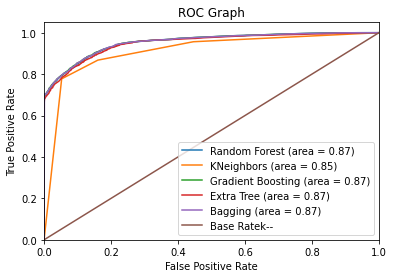

In [69]:
# Create ROC Graph

lr_ev, lr_evn, lr_thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
# svm_ev, svm_evn, svm_thresholds = roc_curve(y_test, svm.predict_proba(X_test)[:,1])
tree_ev, tree_evn, tree_thresholds = roc_curve(y_test, tree.predict_proba(X_test)[:,1])
rf_ev, rf_evn, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
gbc_ev, gbc_evn, gbc_thresholds = roc_curve(y_test, gbc.predict_proba(X_test)[:,1])
knn_ev, knn_evn, knn_thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
etc_ev, etc_evn, etc_thresholds = roc_curve(y_test, etc.predict_proba(X_test)[:,1])
bag_ev, bag_evn, bag_thresholds = roc_curve(y_test, bag.predict_proba(X_test)[:,1])

plt.figure()

# Plot Support Vector Machine ROC
# plt.plot(svm_ev, svm_evn, label='SVM (area = %0.2f)' % svm_roc_auc)
# Plot Random Forest ROC
plt.plot(rf_ev, rf_evn, label='Random Forest (area = %0.2f)' % rf_roc_auc)
# Plot KNeighbors ROC
plt.plot(knn_ev, knn_evn, label='KNeighbors (area = %0.2f)' % knn_roc_auc)
# Plot Gradient Boosting ROC
plt.plot(gbc_ev, gbc_evn, label='Gradient Boosting (area = %0.2f)' % gbc_roc_auc)
# Plot Extra Tree ROC
plt.plot(etc_ev, etc_evn, label='Extra Tree (area = %0.2f)' % etc_roc_auc)
# # Plot XGBClassifier ROC
# plt.plot(xgb_ev, xgb_evn, label='XGBClassifier (area = %0.2f)' % xgb_roc_auc)
# Plot Bagging ROC
plt.plot(bag_ev, bag_evn, label='Bagging (area = %0.2f)' % bag_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

In [70]:
#Split train and test
X=df.drop('Drug', axis=1)
#Feature Scaling
scaler=StandardScaler()
X=scaler.fit_transform(X)

y=df['Drug']
y=y.map({'gabapentin': 1, 'hydrocodone':0, 'neurontin': 1, 'oxycodone': 1, 'tramadol':1  })
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25,stratify=y)

lr.fit(X_train, y_train)
y_lr_pred = lr.predict(X_test);
lr_roc_auc = roc_auc_score(y_test, lr.predict(X_test))
svm.fit(X_train, y_train)
y_svm_pred = svm.predict(X_test);
svm_roc_auc = roc_auc_score(y_test, svm.predict(X_test))
tree.fit(X_train, y_train)
y_tree_pred = tree.predict(X_test);
tree_roc_auc = roc_auc_score(y_test, tree.predict(X_test))
rf.fit(X_train, y_train)
y_rf_pred = rf.predict(X_test);
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
gbc.fit(X_train, y_train)
y_gbc_pred = gbc.predict(X_test);
gbc_roc_auc = roc_auc_score(y_test, gbc.predict(X_test))
# xgb.fit(X_train, y_train)
# y_xgb_pred = xgb.predict(X_test);
# xgb_roc_auc = roc_auc_score(y_test, xgb.predict(X_test))
etc.fit(X_train, y_train)
y_etc_pred = etc.predict(X_test);
etc_roc_auc = roc_auc_score(y_test, etc.predict(X_test))
knn.fit(X_train, y_train)
y_knn_pred = knn.predict(X_test);
knn_roc_auc = roc_auc_score(y_test, knn.predict(X_test))
bag.fit(X_train, y_train)
y_bag_pred = bag.predict(X_test);
bag_roc_auc = roc_auc_score(y_test, bag.predict(X_test))

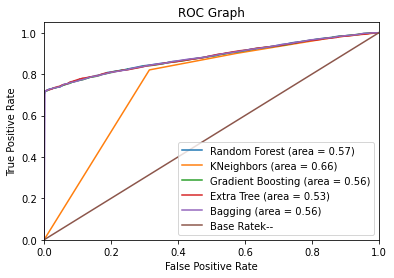

In [71]:
# Create ROC Graph

lr_ev, lr_evn, lr_thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
# svm_ev, svm_evn, svm_thresholds = roc_curve(y_test, svm.predict_proba(X_test)[:,1])
tree_ev, tree_evn, tree_thresholds = roc_curve(y_test, tree.predict_proba(X_test)[:,1])
rf_ev, rf_evn, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
gbc_ev, gbc_evn, gbc_thresholds = roc_curve(y_test, gbc.predict_proba(X_test)[:,1])
knn_ev, knn_evn, knn_thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
etc_ev, etc_evn, etc_thresholds = roc_curve(y_test, etc.predict_proba(X_test)[:,1])
bag_ev, bag_evn, bag_thresholds = roc_curve(y_test, bag.predict_proba(X_test)[:,1])

plt.figure()

# # Plot Support Vector Machine ROC
# plt.plot(svm_ev, svm_evn, label='SVM (area = %0.2f)' % svm_roc_auc)
# Plot Random Forest ROC
plt.plot(rf_ev, rf_evn, label='Random Forest (area = %0.2f)' % rf_roc_auc)
# Plot KNeighbors ROC
plt.plot(knn_ev, knn_evn, label='KNeighbors (area = %0.2f)' % knn_roc_auc)
# Plot Gradient Boosting ROC
plt.plot(gbc_ev, gbc_evn, label='Gradient Boosting (area = %0.2f)' % gbc_roc_auc)
# Plot Extra Tree ROC
plt.plot(etc_ev, etc_evn, label='Extra Tree (area = %0.2f)' % etc_roc_auc)
# # Plot XGBClassifier ROC
# plt.plot(xgb_ev, xgb_evn, label='XGBClassifier (area = %0.2f)' % xgb_roc_auc)
# Plot Bagging ROC
plt.plot(bag_ev, bag_evn, label='Bagging (area = %0.2f)' % bag_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

In [72]:
#Split train and test
X=df.drop('Drug', axis=1)
#Feature Scaling
scaler=StandardScaler()
X=scaler.fit_transform(X)

y=df['Drug']
y=y.map({'gabapentin': 1, 'hydrocodone':1, 'neurontin': 0, 'oxycodone': 1, 'tramadol':1  })
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25,stratify=y)

lr.fit(X_train, y_train)
y_lr_pred = lr.predict(X_test);
lr_roc_auc = roc_auc_score(y_test, lr.predict(X_test))
svm.fit(X_train, y_train)
y_svm_pred = svm.predict(X_test);
svm_roc_auc = roc_auc_score(y_test, svm.predict(X_test))
tree.fit(X_train, y_train)
y_tree_pred = tree.predict(X_test);
tree_roc_auc = roc_auc_score(y_test, tree.predict(X_test))
rf.fit(X_train, y_train)
y_rf_pred = rf.predict(X_test);
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
gbc.fit(X_train, y_train)
y_gbc_pred = gbc.predict(X_test);
gbc_roc_auc = roc_auc_score(y_test, gbc.predict(X_test))
# xgb.fit(X_train, y_train)
# y_xgb_pred = xgb.predict(X_test);
# xgb_roc_auc = roc_auc_score(y_test, xgb.predict(X_test))
etc.fit(X_train, y_train)
y_etc_pred = etc.predict(X_test);
etc_roc_auc = roc_auc_score(y_test, etc.predict(X_test))
knn.fit(X_train, y_train)
y_knn_pred = knn.predict(X_test);
knn_roc_auc = roc_auc_score(y_test, knn.predict(X_test))
bag.fit(X_train, y_train)
y_bag_pred = bag.predict(X_test);
bag_roc_auc = roc_auc_score(y_test, bag.predict(X_test))

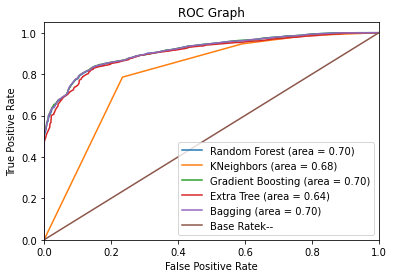

In [73]:
# Create ROC Graph

lr_ev, lr_evn, lr_thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
# svm_ev, svm_evn, svm_thresholds = roc_curve(y_test, svm.predict_proba(X_test)[:,1])
tree_ev, tree_evn, tree_thresholds = roc_curve(y_test, tree.predict_proba(X_test)[:,1])
rf_ev, rf_evn, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
gbc_ev, gbc_evn, gbc_thresholds = roc_curve(y_test, gbc.predict_proba(X_test)[:,1])
knn_ev, knn_evn, knn_thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
etc_ev, etc_evn, etc_thresholds = roc_curve(y_test, etc.predict_proba(X_test)[:,1])
bag_ev, bag_evn, bag_thresholds = roc_curve(y_test, bag.predict_proba(X_test)[:,1])

plt.figure()

# Plot Support Vector Machine ROC
# plt.plot(svm_ev, svm_evn, label='SVM (area = %0.2f)' % svm_roc_auc)
# Plot Random Forest ROC
plt.plot(rf_ev, rf_evn, label='Random Forest (area = %0.2f)' % rf_roc_auc)
# Plot KNeighbors ROC
plt.plot(knn_ev, knn_evn, label='KNeighbors (area = %0.2f)' % knn_roc_auc)
# Plot Gradient Boosting ROC
plt.plot(gbc_ev, gbc_evn, label='Gradient Boosting (area = %0.2f)' % gbc_roc_auc)
# Plot Extra Tree ROC
plt.plot(etc_ev, etc_evn, label='Extra Tree (area = %0.2f)' % etc_roc_auc)
# # Plot XGBClassifier ROC
# plt.plot(xgb_ev, xgb_evn, label='XGBClassifier (area = %0.2f)' % xgb_roc_auc)
# Plot Bagging ROC
plt.plot(bag_ev, bag_evn, label='Bagging (area = %0.2f)' % bag_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

In [74]:
#Split train and test
X=df.drop('Drug', axis=1)
#Feature Scaling
scaler=StandardScaler()
X=scaler.fit_transform(X)

y=df['Drug']
y=y.map({'gabapentin': 1, 'hydrocodone':1, 'neurontin': 1, 'oxycodone': 0, 'tramadol':1  })
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25,stratify=y)

lr.fit(X_train, y_train)
y_lr_pred = lr.predict(X_test);
lr_roc_auc = roc_auc_score(y_test, lr.predict(X_test))
svm.fit(X_train, y_train)
y_svm_pred = svm.predict(X_test);
svm_roc_auc = roc_auc_score(y_test, svm.predict(X_test))
tree.fit(X_train, y_train)
y_tree_pred = tree.predict(X_test);
tree_roc_auc = roc_auc_score(y_test, tree.predict(X_test))
rf.fit(X_train, y_train)
y_rf_pred = rf.predict(X_test);
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
gbc.fit(X_train, y_train)
y_gbc_pred = gbc.predict(X_test);
gbc_roc_auc = roc_auc_score(y_test, gbc.predict(X_test))
# xgb.fit(X_train, y_train)
# y_xgb_pred = xgb.predict(X_test);
# xgb_roc_auc = roc_auc_score(y_test, xgb.predict(X_test))
etc.fit(X_train, y_train)
y_etc_pred = etc.predict(X_test);
etc_roc_auc = roc_auc_score(y_test, etc.predict(X_test))
knn.fit(X_train, y_train)
y_knn_pred = knn.predict(X_test);
knn_roc_auc = roc_auc_score(y_test, knn.predict(X_test))
bag.fit(X_train, y_train)
y_bag_pred = bag.predict(X_test);
bag_roc_auc = roc_auc_score(y_test, bag.predict(X_test))

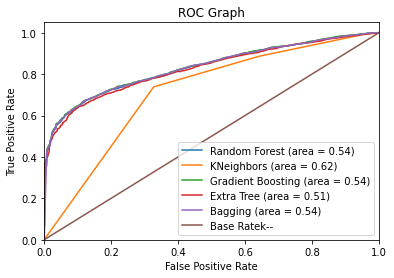

In [75]:
# Create ROC Graph

lr_ev, lr_evn, lr_thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
# svm_ev, svm_evn, svm_thresholds = roc_curve(y_test, svm.predict_proba(X_test)[:,1])
tree_ev, tree_evn, tree_thresholds = roc_curve(y_test, tree.predict_proba(X_test)[:,1])
rf_ev, rf_evn, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
gbc_ev, gbc_evn, gbc_thresholds = roc_curve(y_test, gbc.predict_proba(X_test)[:,1])
knn_ev, knn_evn, knn_thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
etc_ev, etc_evn, etc_thresholds = roc_curve(y_test, etc.predict_proba(X_test)[:,1])
bag_ev, bag_evn, bag_thresholds = roc_curve(y_test, bag.predict_proba(X_test)[:,1])

plt.figure()

# Plot Support Vector Machine ROC
# plt.plot(svm_ev, svm_evn, label='SVM (area = %0.2f)' % svm_roc_auc)
# Plot Random Forest ROC
plt.plot(rf_ev, rf_evn, label='Random Forest (area = %0.2f)' % rf_roc_auc)
# Plot KNeighbors ROC
plt.plot(knn_ev, knn_evn, label='KNeighbors (area = %0.2f)' % knn_roc_auc)
# Plot Gradient Boosting ROC
plt.plot(gbc_ev, gbc_evn, label='Gradient Boosting (area = %0.2f)' % gbc_roc_auc)
# Plot Extra Tree ROC
plt.plot(etc_ev, etc_evn, label='Extra Tree (area = %0.2f)' % etc_roc_auc)
# # Plot XGBClassifier ROC
# plt.plot(xgb_ev, xgb_evn, label='XGBClassifier (area = %0.2f)' % xgb_roc_auc)
# Plot Bagging ROC
plt.plot(bag_ev, bag_evn, label='Bagging (area = %0.2f)' % bag_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

In [76]:
#Split train and test
X=df.drop('Drug', axis=1)
#Feature Scaling
scaler=StandardScaler()
X=scaler.fit_transform(X)

y=df['Drug']
y=y.map({'gabapentin': 1, 'hydrocodone':1, 'neurontin': 1, 'oxycodone': 1, 'tramadol':0})
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25,stratify=y)

lr.fit(X_train, y_train)
y_lr_pred = lr.predict(X_test);
lr_roc_auc = roc_auc_score(y_test, lr.predict(X_test))
svm.fit(X_train, y_train)
y_svm_pred = svm.predict(X_test);
svm_roc_auc = roc_auc_score(y_test, svm.predict(X_test))
tree.fit(X_train, y_train)
y_tree_pred = tree.predict(X_test);
tree_roc_auc = roc_auc_score(y_test, tree.predict(X_test))
rf.fit(X_train, y_train)
y_rf_pred = rf.predict(X_test);
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
gbc.fit(X_train, y_train)
y_gbc_pred = gbc.predict(X_test);
gbc_roc_auc = roc_auc_score(y_test, gbc.predict(X_test))
# xgb.fit(X_train, y_train)
# y_xgb_pred = xgb.predict(X_test);
# xgb_roc_auc = roc_auc_score(y_test, xgb.predict(X_test))
etc.fit(X_train, y_train)
y_etc_pred = etc.predict(X_test);
etc_roc_auc = roc_auc_score(y_test, etc.predict(X_test))
knn.fit(X_train, y_train)
y_knn_pred = knn.predict(X_test);
knn_roc_auc = roc_auc_score(y_test, knn.predict(X_test))
bag.fit(X_train, y_train)
y_bag_pred = bag.predict(X_test);
bag_roc_auc = roc_auc_score(y_test, bag.predict(X_test))

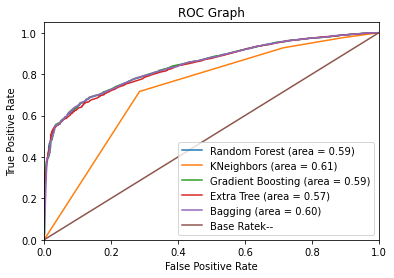

In [77]:
# Create ROC Graph

lr_ev, lr_evn, lr_thresholds = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
# svm_ev, svm_evn, svm_thresholds = roc_curve(y_test, svm.predict_proba(X_test)[:,1])
tree_ev, tree_evn, tree_thresholds = roc_curve(y_test, tree.predict_proba(X_test)[:,1])
rf_ev, rf_evn, rf_thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
gbc_ev, gbc_evn, gbc_thresholds = roc_curve(y_test, gbc.predict_proba(X_test)[:,1])
knn_ev, knn_evn, knn_thresholds = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
etc_ev, etc_evn, etc_thresholds = roc_curve(y_test, etc.predict_proba(X_test)[:,1])
bag_ev, bag_evn, bag_thresholds = roc_curve(y_test, bag.predict_proba(X_test)[:,1])

plt.figure()

# Plot Support Vector Machine ROC
# plt.plot(svm_ev, svm_evn, label='SVM (area = %0.2f)' % svm_roc_auc)
# Plot Random Forest ROC
plt.plot(rf_ev, rf_evn, label='Random Forest (area = %0.2f)' % rf_roc_auc)
# Plot KNeighbors ROC
plt.plot(knn_ev, knn_evn, label='KNeighbors (area = %0.2f)' % knn_roc_auc)
# Plot Gradient Boosting ROC
plt.plot(gbc_ev, gbc_evn, label='Gradient Boosting (area = %0.2f)' % gbc_roc_auc)
# Plot Extra Tree ROC
plt.plot(etc_ev, etc_evn, label='Extra Tree (area = %0.2f)' % etc_roc_auc)
# # Plot XGBClassifier ROC
# plt.plot(xgb_ev, xgb_evn, label='XGBClassifier (area = %0.2f)' % xgb_roc_auc)
# Plot Bagging ROC
plt.plot(bag_ev, bag_evn, label='Bagging (area = %0.2f)' % bag_roc_auc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()